In [1]:
!pip install keras-tcn
!pip install keras-tcn --no-dependencies

     |████████████████████████████████| 1.1 MB 8.9 MB/s 
     |████████████████████████████████| 462 kB 46.0 MB/s 


In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np

import keras 
import pandas as pd


from keras.models import Sequential
from keras.layers import Dense 

from keras.layers import Dropout

from keras.layers import LSTM

from keras.layers import *


from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping


from keras.layers import Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D



from keras.layers import Dense, Embedding, LSTM, Bidirectional

from tcn import TCN, tcn_full_summary

DATA

In [3]:
df=pd.read_csv("GOOG.csv")
print("Number of rows and columns:", df.shape)
df.head(5)
training_set = df.iloc[:1052, 4:5].values

test_set = df.iloc[1052:, 4:5].values
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1052):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],  X_train.shape[1], 1, 1))
X_train.shape

Number of rows and columns: (1503, 7)


(992, 60, 1, 1)

TCN Model

In [4]:
dataset_train = df.iloc[:1052, 4:5]
dataset_test = df.iloc[1052:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(60, 511):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

y =  dataset_test.values.reshape(451,) 
# (459, 60, 1)

(511, 1)
(451, 60, 1)


In [5]:
np.random.seed(1)
model = Sequential()
model.add(TCN(nb_filters=64, kernel_size=5, nb_stacks=1, dilations=[1, 2, 4, 8, 16 ], padding='causal', use_skip_connections=False, dropout_rate=0.1, return_sequences=False, activation='relu', input_shape = (X_train.shape[1], 1)))
#model.add(Dropout(0.1))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
31/31 [==============================] - 17s 13ms/step - loss: 2.5153
Epoch 2/50
31/31 [==============================] - 1s 13ms/step - loss: 0.1469
Epoch 3/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0882
Epoch 4/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0620
Epoch 5/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0522
Epoch 6/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0386
Epoch 7/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0305
Epoch 8/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0277
Epoch 9/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0247
Epoch 10/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0195
Epoch 11/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0192
Epoch 12/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0156
Epoch 13/50
31/31 [=================

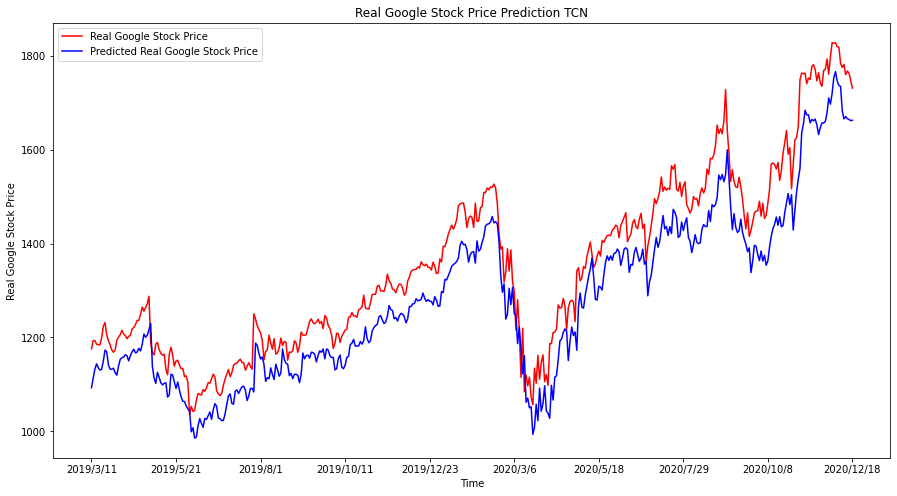

In [6]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Google Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Real Google Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Real Google Stock Price Prediction TCN')
plt.xlabel('Time')
plt.ylabel('Real Google Stock Price')
plt.legend() 
plt.savefig("Real Google TCN")
plt.show()

In [7]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

72.70324006170316

In [8]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

78.72101527692686

TCN + GRU model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 gru (GRU)                      (None, 200)          121800      ['input_1[0][0]']                
                                                                                                  
 tcn_1 (TCN)                    (None, 64)           185408      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 1)            201         ['gru[0][0]']                    
                                                                                              

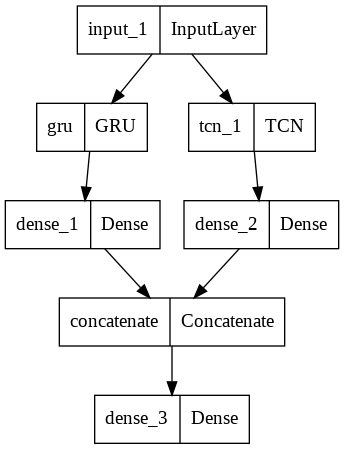

In [9]:
np.random.seed(1)


from keras.layers import Input
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from keras.layers.merge import concatenate
from keras.models import Model

visible = Input(shape=(60,1))

#GRU
gru1 = GRU(units = 200, input_shape = (X_train.shape[1], 1))(visible)
out1 = Dense(units = 1)(gru1)

#TCN
tcn1 = TCN(nb_filters=64, kernel_size=5, nb_stacks=1, dilations=[1, 2, 4, 8, 16 ], padding='causal', use_skip_connections=False, dropout_rate=0, return_sequences=False, activation='relu', input_shape = (X_train.shape[1], 1))(visible)
out2 = Dense(units = 1)(tcn1)

# merge interpretation
merge = concatenate([out1, out2])

# output
output = Dense(1)(merge)
model = Model(inputs=visible, outputs=output)

# summarize layers
print(model.summary())

# plot graph
plot_model(model, to_file='shared_feature_extractor Google.png')

In [10]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 3s 13ms/step - loss: 7.9526
Epoch 2/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0210
Epoch 3/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0095
Epoch 4/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0062
Epoch 5/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0101
Epoch 6/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0047
Epoch 7/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0041
Epoch 8/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0047
Epoch 9/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0036
Epoch 10/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0036
Epoch 11/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0050
Epoch 12/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0034
Epoch 13/30
31/31 [==================

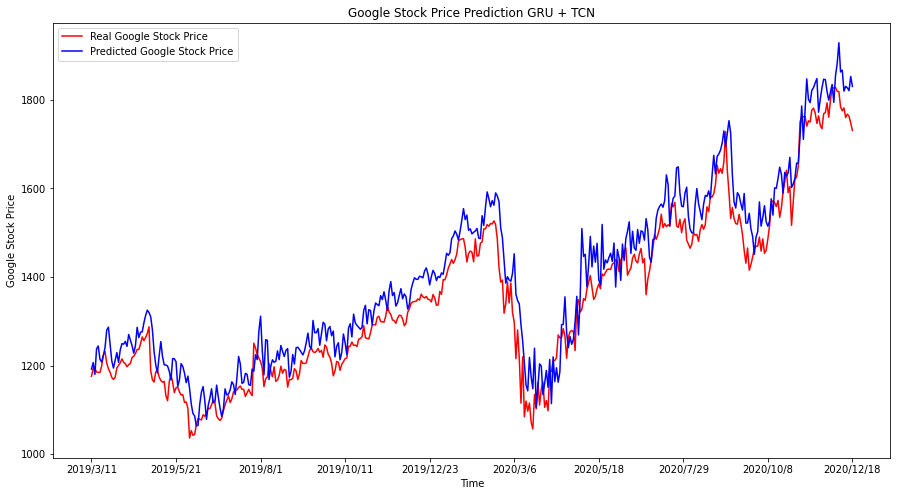

In [11]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Google Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Google Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Google Stock Price Prediction GRU + TCN')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.savefig("Google GRU + TCN")
plt.show() 

In [12]:
abse = mean_absolute_error(predicted_stock_price,y)
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
print(abse, rmse)

49.21071257282428 59.52540581341913


CNN LSTM MODEL

In [13]:

dataset_train = df.iloc[:1052, 4:5]
dataset_test = df.iloc[1052:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(60, 511):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1, 1))
print(X_test.shape)

y =  dataset_test.values.reshape(451,) 
# (459, 60, 1)

(511, 1)
(451, 60, 1, 1)


In [14]:
np.random.seed(1)

model = Sequential()

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape = (X_train.shape[1],1, 1)))

model.add(TimeDistributed(MaxPooling1D(pool_size=1)))

model.add(TimeDistributed(Flatten()))

model.add(GRU(units = 700)) #, return_sequences = True

model.add(Dropout(0.1))


model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
31/31 [==============================] - 2s 15ms/step - loss: 0.0202
Epoch 2/50
31/31 [==============================] - 0s 12ms/step - loss: 6.8490e-04
Epoch 3/50
31/31 [==============================] - 0s 12ms/step - loss: 5.0319e-04
Epoch 4/50
31/31 [==============================] - 0s 12ms/step - loss: 5.4198e-04
Epoch 5/50
31/31 [==============================] - 0s 12ms/step - loss: 5.4277e-04
Epoch 6/50
31/31 [==============================] - 0s 12ms/step - loss: 4.4734e-04
Epoch 7/50
31/31 [==============================] - 0s 12ms/step - loss: 4.8104e-04
Epoch 8/50
31/31 [==============================] - 0s 12ms/step - loss: 4.7210e-04
Epoch 9/50
31/31 [==============================] - 0s 12ms/step - loss: 4.6181e-04
Epoch 10/50
31/31 [==============================] - 0s 12ms/step - loss: 4.5296e-04
Epoch 11/50
31/31 [==============================] - 0s 13ms/step - loss: 4.7667e-04
Epoch 12/50
31/31 [==============================] - 0s 12ms/step - loss: 4.74

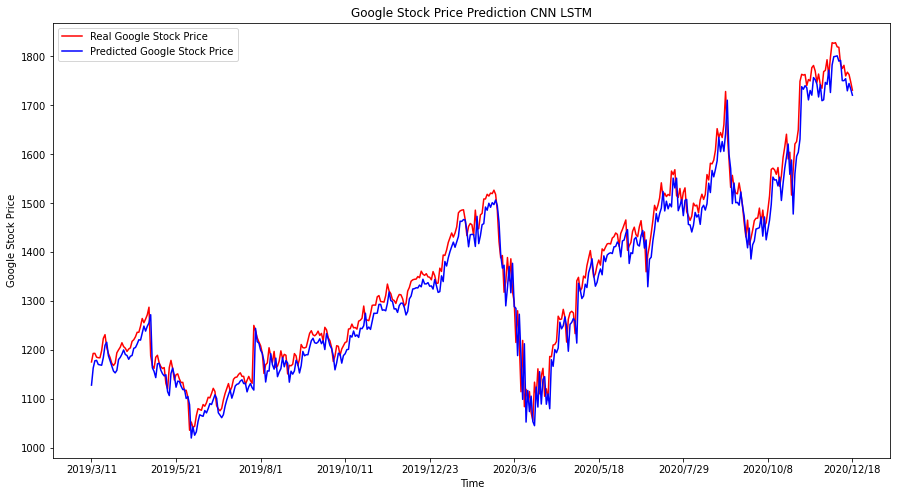

In [15]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Google Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Google Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Google Stock Price Prediction CNN LSTM')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend() 
plt.savefig("Google CNN LSTM")
plt.show()

In [16]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

26.801228958581618

In [17]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

34.01675411095127

CNN

In [18]:
df=pd.read_csv("GOOG.csv")
print("Number of rows and columns:", df.shape)
df.head(5)
training_set = df.iloc[:1052, 4:5].values

test_set = df.iloc[1052:, 4:5].values
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1052):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1], 1))
X_train.shape

Number of rows and columns: (1503, 7)


(992, 1, 60, 1)

In [19]:
np.random.seed(1)

model = Sequential()

model.add(TimeDistributed(Conv1D(filters=128, kernel_size=11, activation='relu'), input_shape = (1, X_train.shape[2],1)))
print(model.output_shape)
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
print(model.output_shape)
model.add(TimeDistributed(Flatten()))
print(model.output_shape)


model.add(Dense(units = 1))
print(model.output_shape)

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

(None, 1, 50, 128)
(None, 1, 25, 128)
(None, 1, 3200)
(None, 1, 1)
Epoch 1/30
31/31 [==============================] - 1s 2ms/step - loss: 0.1166
Epoch 2/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0684
Epoch 3/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0647
Epoch 4/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0647
Epoch 5/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0642
Epoch 6/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0649
Epoch 7/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0648
Epoch 8/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0648
Epoch 9/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0648
Epoch 10/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0642
Epoch 11/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0638
Epoch 12/30
31/31 [==============================] - 0s 2ms/st

In [20]:

dataset_train = df.iloc[:1052, 4:5]
dataset_test = df.iloc[1052:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(60, 511):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1],1))
print(X_test.shape)
# (459, 60, 1)

(511, 1)
(451, 1, 60, 1)


In [21]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(451,1)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

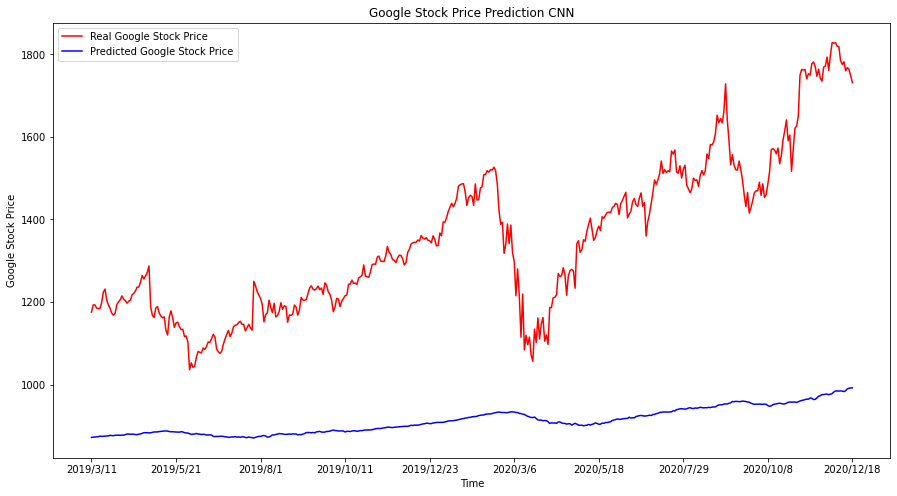

In [22]:

predicted_stock_price = model.predict(X_test).reshape(-1,1)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Google Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Google Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Google Stock Price Prediction CNN')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.savefig("Google CNN")
plt.show() 

In [23]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

439.3999500036204

In [24]:
rmse=math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

468.43286818306325

LSTM GRU MODEL

In [25]:

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1052):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],  X_train.shape[1], 1))
X_train.shape

(992, 60, 1)

In [26]:
np.random.seed(1)
model = Sequential()
model.add(LSTM(units = 700, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(GRU(units = 700,  input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 3s 32ms/step - loss: 0.0152
Epoch 2/30
31/31 [==============================] - 1s 29ms/step - loss: 0.0022
Epoch 3/30
31/31 [==============================] - 1s 29ms/step - loss: 0.0011
Epoch 4/30
31/31 [==============================] - 1s 29ms/step - loss: 7.9461e-04
Epoch 5/30
31/31 [==============================] - 1s 29ms/step - loss: 7.3184e-04
Epoch 6/30
31/31 [==============================] - 1s 29ms/step - loss: 9.6096e-04
Epoch 7/30
31/31 [==============================] - 1s 29ms/step - loss: 6.4016e-04
Epoch 8/30
31/31 [==============================] - 1s 29ms/step - loss: 6.6862e-04
Epoch 9/30
31/31 [==============================] - 1s 29ms/step - loss: 7.8263e-04
Epoch 10/30
31/31 [==============================] - 1s 29ms/step - loss: 7.2808e-04
Epoch 11/30
31/31 [==============================] - 1s 29ms/step - loss: 7.4291e-04
Epoch 12/30
31/31 [==============================] - 1s 29ms/step - loss: 6.3597e-04
E

TEST DATA

In [27]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:1052, 4:5]
dataset_test = df.iloc[1052:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(60, 511):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)


(511, 1)
(451, 60, 1)


PREDICTION

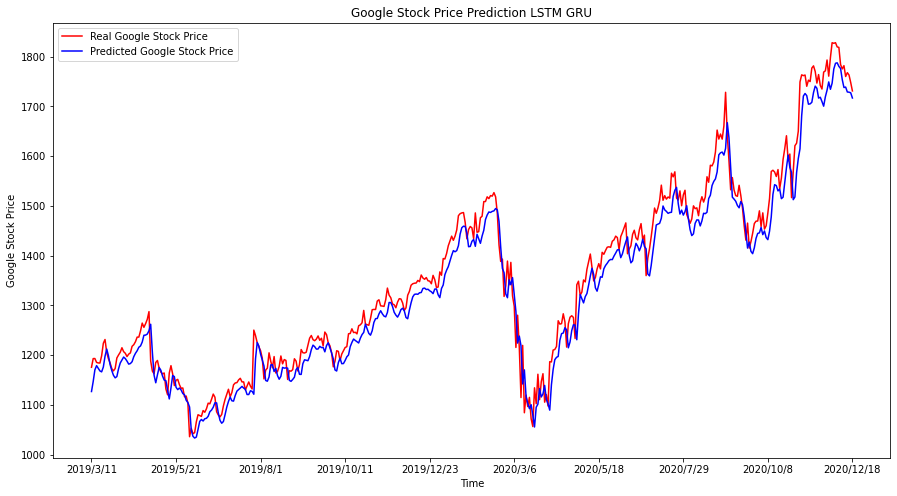

In [28]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Google Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Google Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Google Stock Price Prediction LSTM GRU')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend() 
plt.savefig("Google LSTM GRU")
plt.show()

In [29]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

29.883680002078712

In [30]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

36.54949116706418

LSTM Model

In [31]:
model = Sequential()

model.add(LSTM(units = 700, input_shape = (X_train.shape[1], 1))) 
model.add(Dropout(0.1))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 2s 17ms/step - loss: 0.0602
Epoch 2/30
31/31 [==============================] - 0s 13ms/step - loss: 0.0051
Epoch 3/30
31/31 [==============================] - 0s 13ms/step - loss: 0.0015
Epoch 4/30
31/31 [==============================] - 0s 14ms/step - loss: 0.0012
Epoch 5/30
31/31 [==============================] - 0s 13ms/step - loss: 0.0014
Epoch 6/30
31/31 [==============================] - 0s 14ms/step - loss: 0.0011
Epoch 7/30
31/31 [==============================] - 0s 14ms/step - loss: 0.0011
Epoch 8/30
31/31 [==============================] - 0s 14ms/step - loss: 0.0011
Epoch 9/30
31/31 [==============================] - 0s 14ms/step - loss: 0.0010
Epoch 10/30
31/31 [==============================] - 0s 14ms/step - loss: 0.0011
Epoch 11/30
31/31 [==============================] - 0s 14ms/step - loss: 0.0011
Epoch 12/30
31/31 [==============================] - 0s 14ms/step - loss: 0.0011
Epoch 13/30
31/31 [==================

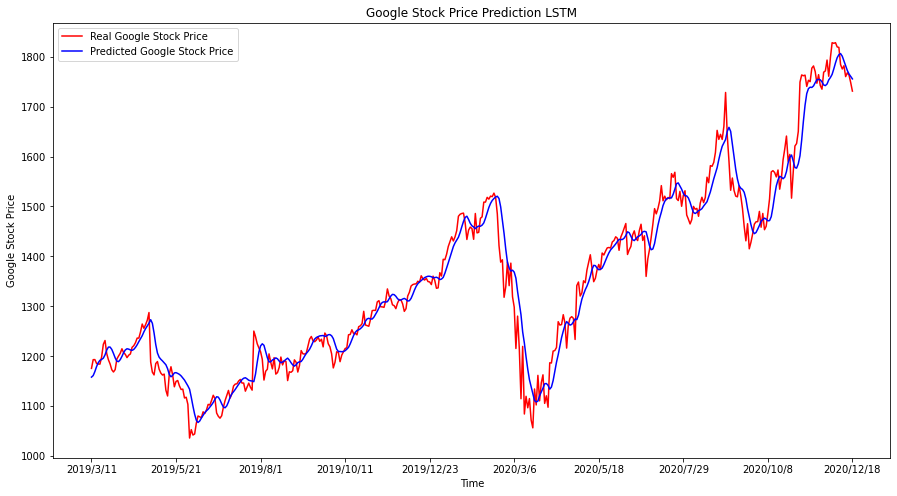

In [32]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Google Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Google Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Google Stock Price Prediction LSTM')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend() 
plt.savefig("Google LSTM")
plt.show()

In [33]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

26.35559433957525

In [34]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

36.92454648385702

RNN MODEL


In [35]:
model = Sequential()

model.add(SimpleRNN(units = 700, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 30, batch_size = 32) 

Epoch 1/30
31/31 [==============================] - 2s 56ms/step - loss: 1.1254
Epoch 2/30
31/31 [==============================] - 1s 37ms/step - loss: 0.5761
Epoch 3/30
31/31 [==============================] - 1s 35ms/step - loss: 0.4216
Epoch 4/30
31/31 [==============================] - 1s 36ms/step - loss: 0.3834
Epoch 5/30
31/31 [==============================] - 1s 36ms/step - loss: 0.3815
Epoch 6/30
31/31 [==============================] - 1s 36ms/step - loss: 0.3901
Epoch 7/30
31/31 [==============================] - 1s 33ms/step - loss: 0.3252
Epoch 8/30
31/31 [==============================] - 1s 35ms/step - loss: 0.2992
Epoch 9/30
31/31 [==============================] - 1s 35ms/step - loss: 0.3114
Epoch 10/30
31/31 [==============================] - 1s 35ms/step - loss: 0.2746
Epoch 11/30
31/31 [==============================] - 1s 36ms/step - loss: 0.2652
Epoch 12/30
31/31 [==============================] - 1s 35ms/step - loss: 0.2266
Epoch 13/30
31/31 [==================

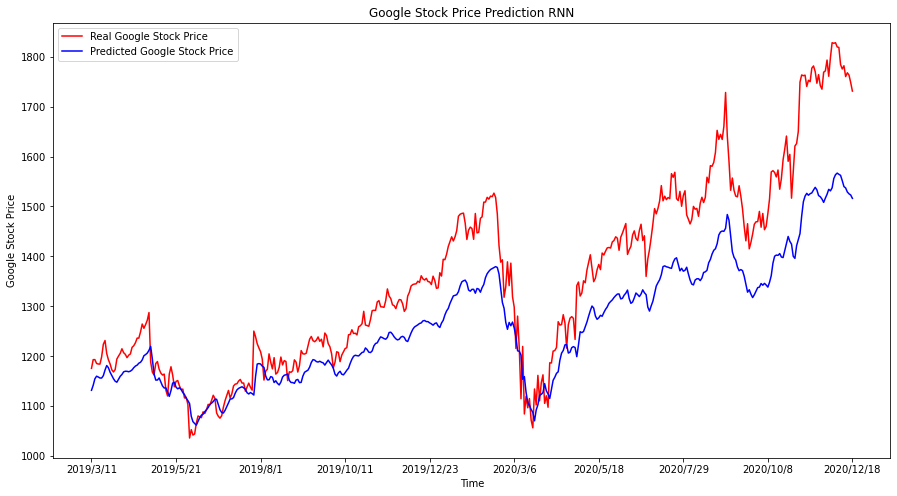

In [36]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Google Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Google Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Google Stock Price Prediction RNN')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend() 
plt.savefig("Google RNN")
plt.show()

In [37]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

91.27717189765798

In [38]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

114.0176215766291

GRU

In [39]:
np.random.seed(1)

model = Sequential()

model.add(GRU(units = 700, input_shape = (X_train.shape[1], 1))) 

model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 2s 14ms/step - loss: 0.0226
Epoch 2/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0014
Epoch 3/30
31/31 [==============================] - 0s 11ms/step - loss: 7.8236e-04
Epoch 4/30
31/31 [==============================] - 0s 11ms/step - loss: 7.9725e-04
Epoch 5/30
31/31 [==============================] - 0s 11ms/step - loss: 7.9351e-04
Epoch 6/30
31/31 [==============================] - 0s 11ms/step - loss: 8.1661e-04
Epoch 7/30
31/31 [==============================] - 0s 11ms/step - loss: 7.3317e-04
Epoch 8/30
31/31 [==============================] - 0s 11ms/step - loss: 7.5221e-04
Epoch 9/30
31/31 [==============================] - 0s 11ms/step - loss: 7.4458e-04
Epoch 10/30
31/31 [==============================] - 0s 11ms/step - loss: 7.1260e-04
Epoch 11/30
31/31 [==============================] - 0s 11ms/step - loss: 6.6911e-04
Epoch 12/30
31/31 [==============================] - 0s 11ms/step - loss: 6.7460e-

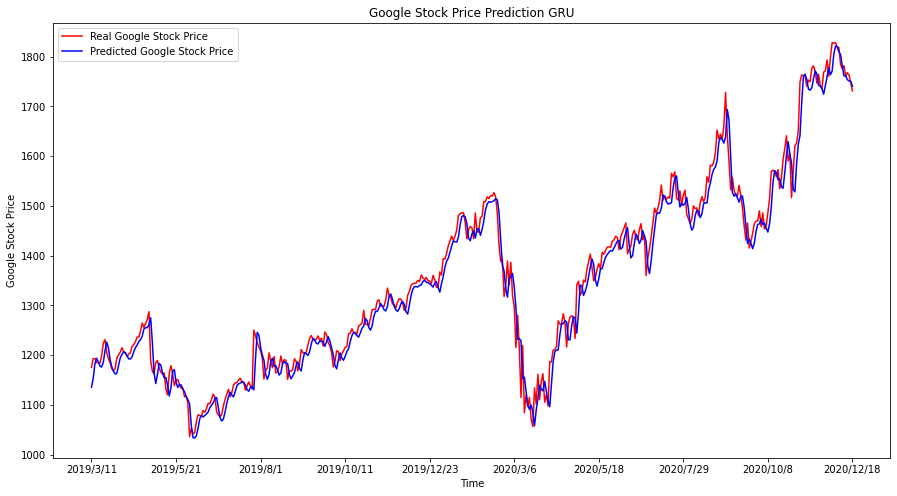

In [40]:

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Google Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Google Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Google Stock Price Prediction GRU')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.savefig("Google GRU")
plt.show() 

In [41]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

21.419064152924054

In [42]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

28.97410203755576

Bi-LSTM

In [43]:
np.random.seed(1)
model = Sequential()

model.add(Bidirectional(LSTM(units = 700, input_shape = (X_train.shape[1], 1)))) 
model.add(Dropout(0.1))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 4s 30ms/step - loss: 0.0310
Epoch 2/30
31/31 [==============================] - 1s 27ms/step - loss: 0.0031
Epoch 3/30
31/31 [==============================] - 1s 27ms/step - loss: 0.0020
Epoch 4/30
31/31 [==============================] - 1s 27ms/step - loss: 0.0018
Epoch 5/30
31/31 [==============================] - 1s 27ms/step - loss: 0.0016
Epoch 6/30
31/31 [==============================] - 1s 27ms/step - loss: 0.0017
Epoch 7/30
31/31 [==============================] - 1s 27ms/step - loss: 0.0017
Epoch 8/30
31/31 [==============================] - 1s 27ms/step - loss: 0.0014
Epoch 9/30
31/31 [==============================] - 1s 27ms/step - loss: 0.0013
Epoch 10/30
31/31 [==============================] - 1s 27ms/step - loss: 0.0013
Epoch 11/30
31/31 [==============================] - 1s 27ms/step - loss: 0.0013
Epoch 12/30
31/31 [==============================] - 1s 27ms/step - loss: 0.0012
Epoch 13/30
31/31 [==================

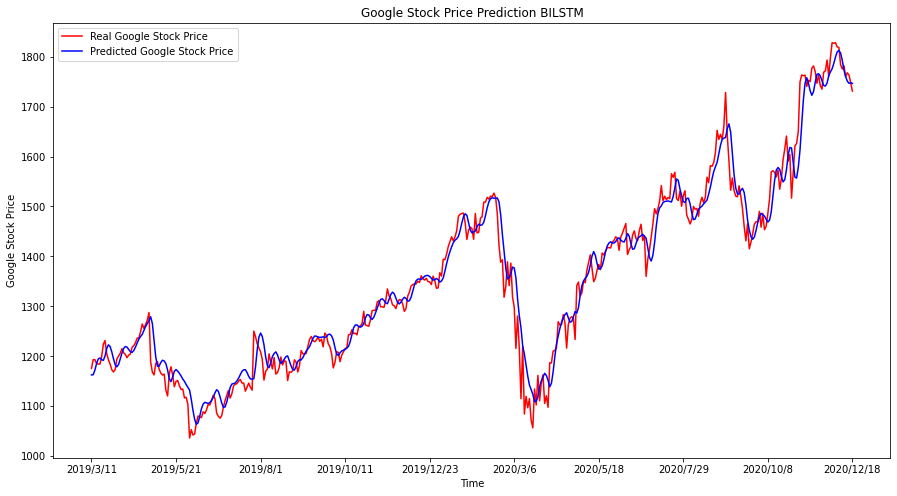

In [44]:

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Google Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Google Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Google Stock Price Prediction BILSTM')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.savefig("Google BILSTM")
plt.show() 

In [45]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

24.137538049715907

In [46]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

33.70298211254973

Bi-GRU

In [47]:
model = Sequential()

model.add(Bidirectional(GRU(units = 700, input_shape = (X_train.shape[1], 1))))
model.add(Dropout(0.1))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 4s 26ms/step - loss: 0.0219
Epoch 2/30
31/31 [==============================] - 1s 22ms/step - loss: 0.0022
Epoch 3/30
31/31 [==============================] - 1s 22ms/step - loss: 0.0016
Epoch 4/30
31/31 [==============================] - 1s 22ms/step - loss: 0.0013
Epoch 5/30
31/31 [==============================] - 1s 22ms/step - loss: 0.0011
Epoch 6/30
31/31 [==============================] - 1s 22ms/step - loss: 8.6161e-04
Epoch 7/30
31/31 [==============================] - 1s 22ms/step - loss: 8.1700e-04
Epoch 8/30
31/31 [==============================] - 1s 22ms/step - loss: 8.9495e-04
Epoch 9/30
31/31 [==============================] - 1s 22ms/step - loss: 7.0017e-04
Epoch 10/30
31/31 [==============================] - 1s 22ms/step - loss: 6.7353e-04
Epoch 11/30
31/31 [==============================] - 1s 22ms/step - loss: 6.5365e-04
Epoch 12/30
31/31 [==============================] - 1s 22ms/step - loss: 8.2491e-04
Epoch 13/

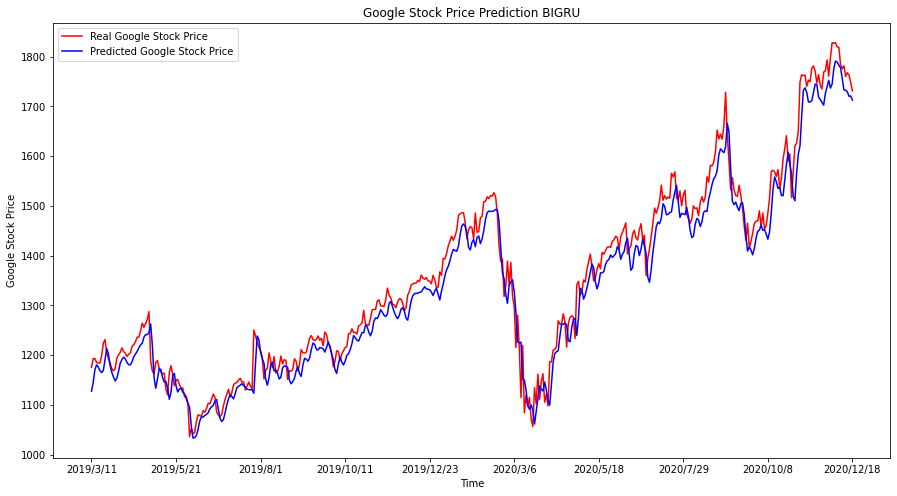

In [48]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Google Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Google Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Google Stock Price Prediction BIGRU')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.savefig("Google BIGRU")
plt.show() 

In [49]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

29.33345821921771

In [50]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

36.177209167786486

Breaking Dataset to Improve Performance

In [51]:
training_set = df.iloc[:, 4:5].values
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output




In [52]:
X_train = []
y_train = []
for i in range(60, 351):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

for i in range(501, 852):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

for i in range(1002, 1353):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],  X_train.shape[1], 1))
X_train.shape

(993, 60, 1)

In [53]:

inputs = df.iloc[:, 4:5].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)




(1503, 1)


In [54]:
X_test = []
y_test = []
for i in range(351, 501):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(df.iloc[i, 4:5].values)

for i in range(852, 1002):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(df.iloc[i, 4:5].values)

for i in range(1353, 1503):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(df.iloc[i, 4:5].values)

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

(450, 60, 1)


In [55]:
np.random.seed(1)

model = Sequential()

model.add(GRU(units = 700, input_shape = (X_train.shape[1], 1))) 

model.add(Dropout(0.2))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
32/32 [==============================] - 2s 19ms/step - loss: 0.0153
Epoch 2/30
32/32 [==============================] - 0s 12ms/step - loss: 5.1910e-04
Epoch 3/30
32/32 [==============================] - 0s 12ms/step - loss: 3.8857e-04
Epoch 4/30
32/32 [==============================] - 0s 14ms/step - loss: 4.3275e-04
Epoch 5/30
32/32 [==============================] - 1s 19ms/step - loss: 5.6632e-04
Epoch 6/30
32/32 [==============================] - 0s 14ms/step - loss: 4.6357e-04
Epoch 7/30
32/32 [==============================] - 0s 12ms/step - loss: 4.0978e-04
Epoch 8/30
32/32 [==============================] - 0s 12ms/step - loss: 3.9250e-04
Epoch 9/30
32/32 [==============================] - 0s 12ms/step - loss: 3.6858e-04
Epoch 10/30
32/32 [==============================] - 0s 12ms/step - loss: 5.5192e-04
Epoch 11/30
32/32 [==============================] - 0s 12ms/step - loss: 4.8141e-04
Epoch 12/30
32/32 [==============================] - 0s 12ms/step - loss: 3.90

In [56]:

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


In [57]:
abse = mean_absolute_error(predicted_stock_price, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)


In [58]:
abse

32.8031393732118

In [59]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y_test))
rmse

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)


40.78115351983642

In [60]:
x1 = df.loc[351:500 , "Date"]
x2 = df.loc[852:1001 , "Date"]
x3 = df.loc[1353: , "Date"]

In [61]:
x = pd.concat([x1,x2,x3], axis =0)

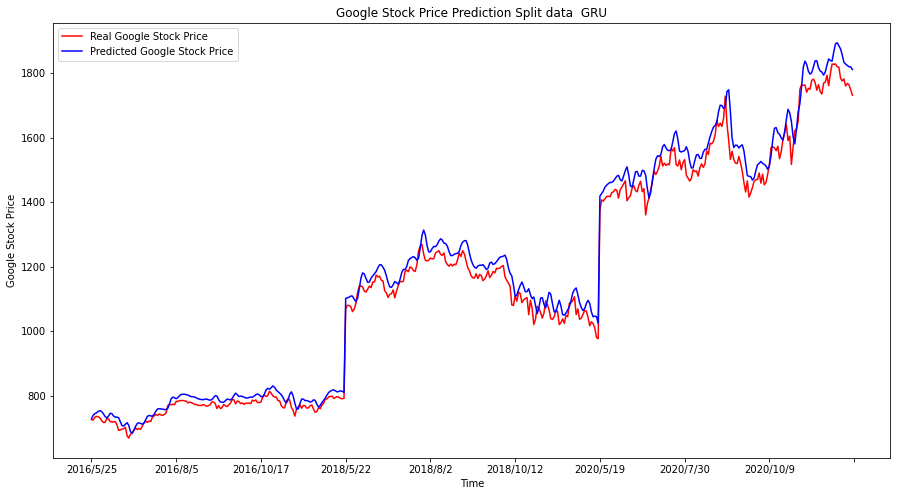

In [62]:

# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y_test, c= "red", label = "Real Google Stock Price")
plt.plot(x,predicted_stock_price, color = "blue", label = "Predicted Google Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Google Stock Price Prediction Split data  GRU')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.savefig("Google Split data GRU")
plt.show() 